In [1]:
%matplotlib inline
import os
from timeit import default_timer as timer
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path_to_data='/scratch/spf248/covid/data'
start_date='01/01/2020'
end_date='04/16/2020'
source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
city_id='UC_NM_MN'
city_name='Jakarta'
freq='SMS'
admin_agg='ADM2_EN'
final_date=date(datetime.today().year, datetime.today().month,1)
initial_date=date(datetime.today().year, datetime.today().month-2,1)

In [3]:
# 0 = Monday, 1=Tuesday, 2=Wednesday...
def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0: # Target day already happened this week
        days_ahead += 7
    return d + timedelta(days_ahead)

In [4]:
print('Import admin data')
start = timer()
admin = gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
print("Done in", round(timer()-start), "sec")  

Import admin data
Done in 62 sec


In [5]:
print('Import trips')
start = timer()
trips = pd.read_csv(os.path.join(path_to_data,source,'processed',country,'OD_'+city_name+'.csv'),index_col=0)
trips.date=pd.to_datetime(trips.date)
print("Done in", round(timer()-start), "sec")  

Import trips


/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Done in 2 sec


In [6]:
print('Spatial Aggregation')
start = timer()
trips=trips.merge(
admin[[admin_id,admin_agg]].rename(columns=lambda x:x+'_origin')).merge(
admin[[admin_id,admin_agg]].rename(columns=lambda x:x+'_destination'))
trips=trips.groupby(['date',admin_agg+'_origin',admin_agg+'_destination'])['trip'].sum()
admin_order=trips.groupby(admin_agg+'_origin').sum().sort_values(ascending=False)
trips=trips[trips.index.get_level_values(admin_agg+'_origin')!=\
trips.index.get_level_values(admin_agg+'_destination')].copy()
print("Done in", round(timer()-start), "sec")  

Spatial Aggregation
Done in 2 sec


In [7]:
print('Temporal Aggregation')
start = timer()
trips=trips.reset_index().groupby(
[pd.Grouper(key='date', freq=freq),admin_agg+'_origin',admin_agg+'_destination'])['trip'].sum()
print("Done in", round(timer()-start), "sec")  

Temporal Aggregation
Done in 0 sec


In [8]:
print('Flow Changes')
start = timer()
trips=pd.concat([trips.xs(final_date,level='date').rename('trip_final'),
trips.xs(initial_date,level='date').rename('trip_initial'),],1)
trips['pct_change']=trips['trip_final'].divide(trips['trip_initial'])-1
print("Done in", round(timer()-start), "sec")  

Flow Changes
Done in 0 sec


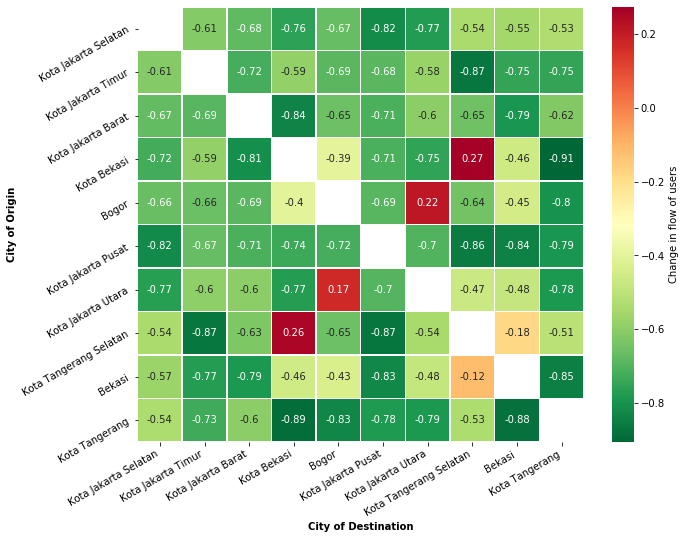

In [14]:
fig,ax=plt.subplots(figsize=(10,8))
df=trips.loc[(trips['trip_initial']>=10),'pct_change'].unstack().loc[admin_order.index[:10]][admin_order.index[:10]]
mask=df.isnull()
sns.heatmap(df,mask=mask,cmap='RdYlGn_r', linewidths=0.5, annot=True, cbar_kws={'label': 'Change in flow of users'})
ax.set_xlabel('City of Destination',fontweight='bold')
ax.set_ylabel('City of Origin',fontweight='bold')
ax.set_xticklabels(ax.get_yticklabels(), rotation = 30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 30, ha='right')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'flows-'+city_name+'.pdf'),bbox_inches='tight')